## Hyperparameter search

Source: https://github.com/itdxer/neupy/blob/master/notebooks/Hyperparameter%20optimization%20for%20Neural%20Networks.ipynb
and http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#id14

```python
Hyperparams to train:
1. lamda
2. number of hidden layers
3. number of hidden units
3. starter learning rate
5. use_sigmoid_h1
6. use_sigmoid_h2```

In [1]:
import time
import os
import re
import sys
import numpy as np

sys.path = sys.path[1:]
sys.path.insert(0, os.path.join(os.getcwd(), "helper_scripts"))  # pretending we are running main.py in jupyter

import global_variables_final_for_git
reload(global_variables_final_for_git)
from global_variables_final_for_git import Global_Vars
from prep_for_model_for_git import Model_preparation

import hyperopt
from hyperopt import fmin
import HPO_helper
reload(HPO_helper)
from HPO_helper import uniform_int, loguniform_int, tpe_method, get_parameter_space_forHPO
import tensorflow_model_for_git
reload(tensorflow_model_for_git)
from tensorflow_model_for_git import Tensorflow_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
class Args(object):
    def __init__(self):
        self.gene = "SIX1"
        self.distance = 150
        self.use_tad_info = True
        self.pcc_lowerlimit_to_filter_dhss = 0.2
        self.filter_tfs_by = "zscore" # or "pcc"
        self.lowerlimit_to_filter_tfs = 6
        self.take_this_many_top_dhss = 4  # all dhss/tfs will already be filtered by pcc(or zscore)
        self.take_this_many_top_tfs = 6
        self.init_wts_type = "corr"
        self.outputDir = "/Users/Dinesh/Dropbox/Github/predicting_gex_with_nn_git/Output/"+self.gene.upper()
        self.use_random_DHSs = True # False
        self.use_random_TFs = True # False
        self.max_iter = 200
        self.plot_all = True

test_idx = 12 # 2 to brain; 6 to ESC; 7 is epithelial; 8 is HSC and B; 12 is muscle; 5 is ES-derived
start_time = time.time()
args = Args()
gv = Global_Vars(args, args.outputDir)  # note this takes in new_output_dir as well in .py scripts

2018-01-26 18:15:00,083: global_variables_final_for_git: INFO    : Setting up the DNase-seq dataframe and gene expression vector..
2018-01-26 18:15:11,545: global_variables_final_for_git: INFO    : Total number of DHS sites originally: 45
2018-01-26 18:15:12,418: global_variables_final_for_git: INFO    : Total number of TFs originally: 71
2018-01-26 18:15:13,450: global_variables_final_for_git: INFO    : Done. Setting up the training and testing split..


In [3]:
gv.df_dhss.transpose().describe()

loc,chr17:17216600-17217400,chr20:51603400-51604000,chr3:75954800-75956800,chr5:159263400-159264000
pcc,-0.576127,-0.251679,0.327612,0.191625
count,127.000000,127.000000,127.000000,127.000000
mean,10.839694,8.145929,10.712785,7.984255
std,0.738792,0.199763,0.865760,0.171920
min,9.395534,7.829723,9.436712,7.642052
25%,10.326987,8.011926,9.917295,7.875748
50%,10.691307,8.099348,10.568669,7.960002
75%,11.452746,8.246146,11.344701,8.042330
max,12.366937,8.839204,12.652677,8.713387


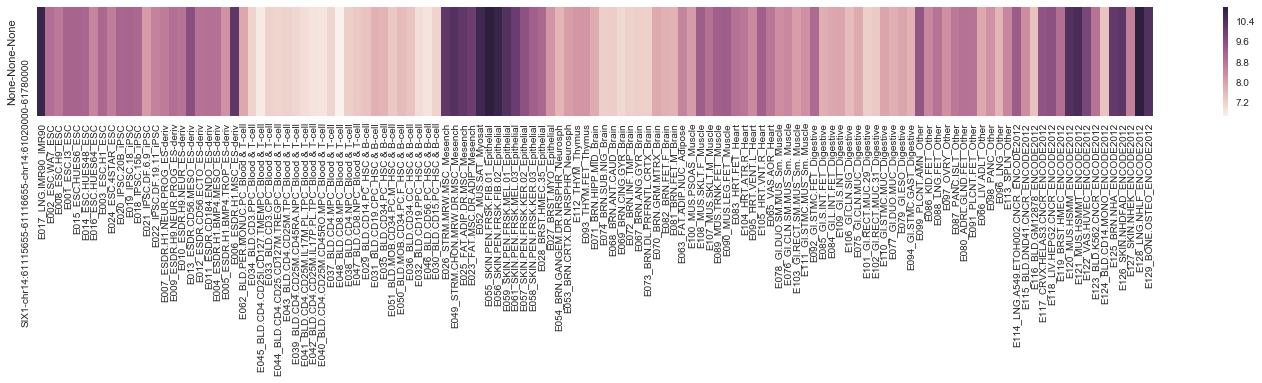

In [4]:
plt.figure(figsize=(25,2))
sns.heatmap(gv.goi.to_frame().transpose())

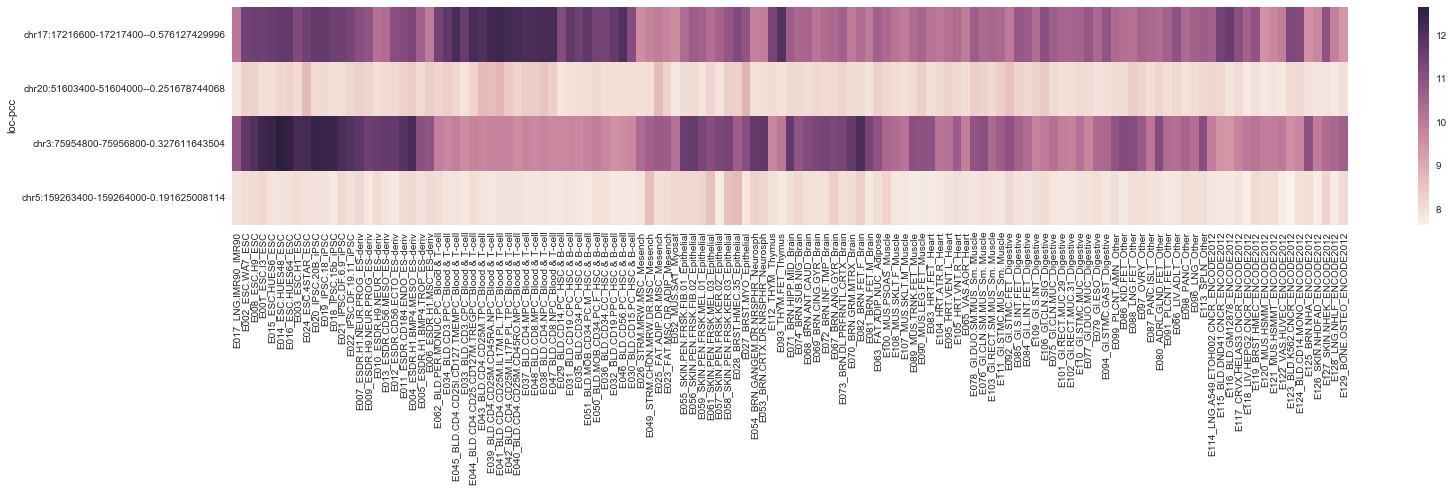

In [5]:
plt.figure(figsize=(25,4))
sns.heatmap( gv.df_dhss)

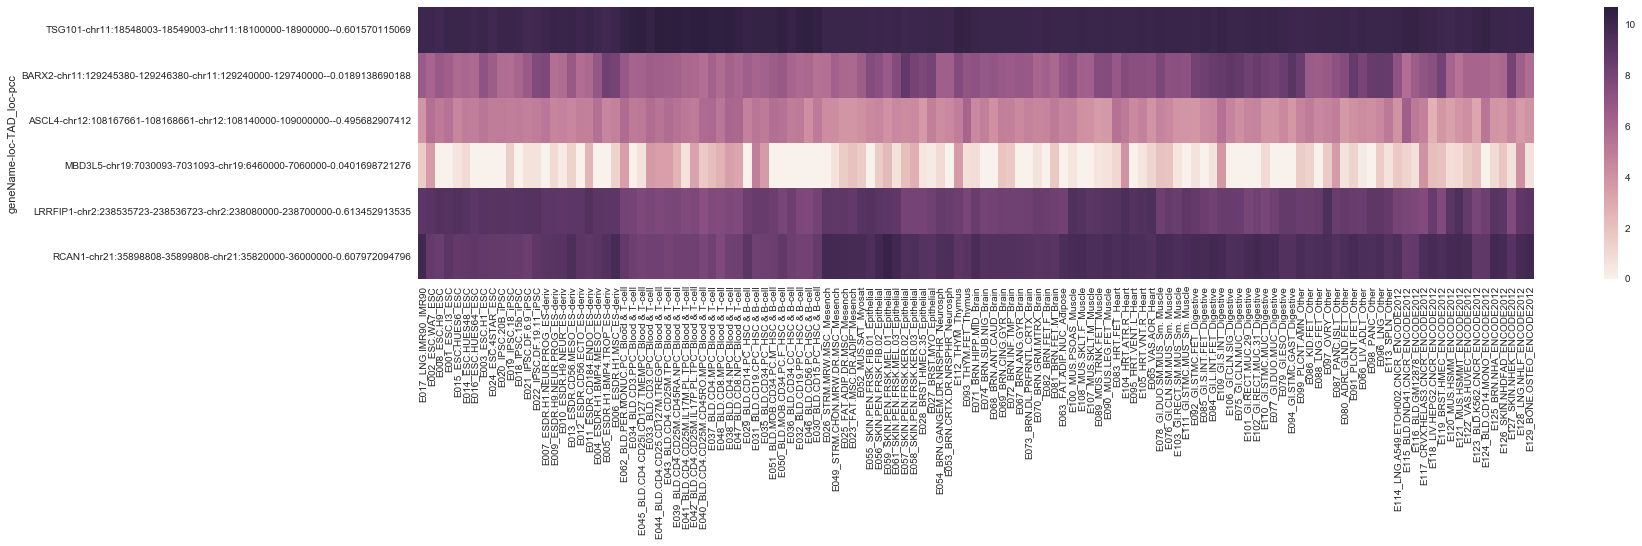

In [6]:
plt.figure(figsize=(25,5))
sns.heatmap(gv.df_tfs)

In [7]:
'''Run HPO on differen train/test splits'''
mp = Model_preparation(gv)
start_time = time.time()

2018-01-26 18:15:17,876: prep_for_model_for_git: INFO    : Preparing the dataframe for train/test splits..


In [8]:
'''Run HPO on differen train/test splits'''
tm = Tensorflow_model(gv, mp, test_eid_group_index=test_idx)

Text(0.5,0.98,u'SIX1, test_idx:12')

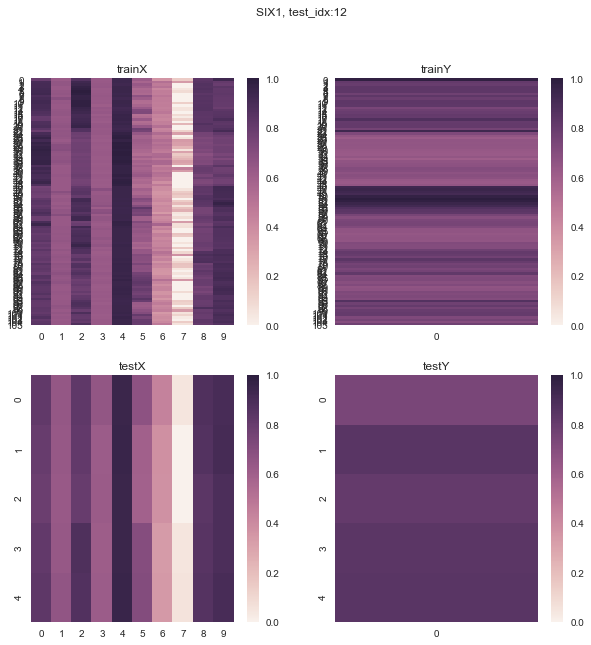

In [9]:
'''Plot train, test X and Y matrices'''
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
sns.heatmap(tm.trainX, vmin=0, vmax=1)
plt.title('trainX')
plt.subplot(2, 2, 2)
sns.heatmap(tm.trainY, vmin=0, vmax=1)
plt.title('trainY')

plt.subplot(2, 2, 3)
sns.heatmap(tm.testX, vmin=0, vmax=1)
plt.title('testX')

plt.subplot(2, 2, 4)
sns.heatmap(tm.testY, vmin=0, vmax=1)
plt.title('testY')
plt.suptitle("{}, test_idx:{}".format(gv.gene_ofInterest, test_idx))

In [10]:
'''Now train and search for HPO'''
trials = hyperopt.Trials()
best_params = hyperopt.fmin(tm.train_tensorflow_nn, trials=trials,
                            space=get_parameter_space_forHPO(tm.trainX),
                            algo=tpe_method, max_evals=10)

to_log = tm.get_log_into_to_save(trials, best_params)
plot_title = re.split(";best_params", to_log)[0]
plot_title_prefix, plot_title_error_msg, plot_title_suffix = re.split(";median_pc_error|;PCC", plot_title)
plot_title = plot_title_prefix + "\nmed_pc_err" + plot_title_error_msg + "\nPCC" + plot_title_suffix
tm.plot_scatter_performance(trials, gv, gv.gene_ofInterest + ";" + plot_title)

print("Total time taken: {}".format(time.time() - start_time))

lamda:3e-06, layer_sizes:[3], loss:0.218046173453, status:ok, yhat_test:[ 0.7461592   0.68378425  0.60848498  0.65662432  0.71711779]
lamda:0.03, layer_sizes:[6, 2], loss:0.165772750974, status:ok, yhat_test:[ 0.73678935  0.69960111  0.62128103  0.76692432  0.76813406]
lamda:0.03, layer_sizes:[5, 1], loss:0.215374395251, status:ok, yhat_test:[ 0.68261611  0.65613467  0.59132093  0.69938099  0.69949758]
lamda:0.03, layer_sizes:[4], loss:0.222402691841, status:ok, yhat_test:[ 0.67584544  0.63176441  0.5593003   0.71020269  0.73857081]
lamda:0.0003, layer_sizes:[5], loss:0.173325195909, status:ok, yhat_test:[ 0.69853425  0.71595019  0.63365763  0.6649909   0.69380099]
lamda:0.0003, layer_sizes:[6, 3], loss:0.120803244412, status:ok, yhat_test:[ 0.92979485  0.75868154  0.6120193   0.70026207  0.71695191]
lamda:3e-07, layer_sizes:[3, 3], loss:0.125951096416, status:ok, yhat_test:[ 0.94409227  0.77182269  0.64042795  0.69406575  0.70734692]
lamda:0.0003, layer_sizes:[6, 3], loss:0.1207973062

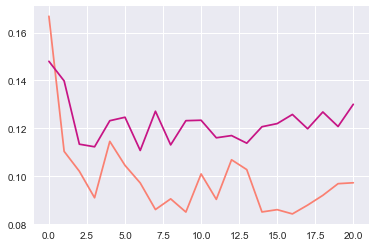

In [11]:
index = np.argmin(trials.losses())
plt.plot(trials.results[index]["train_loss"], color="salmon")
plt.plot(trials.results[index]["val_loss"], color="mediumvioletred")

## Retraining to see improvement in model performance


In [12]:
wts, layer_sizes, lamda, trainX, trainY, nn_updates, b1, g1, b2, g2 = tm.get_params_from_best_trial(index, trials, best_params)

In [13]:
updates = tm.retrain_tensorflow_nn(wts, layer_sizes, lamda, trainX, trainY, nn_updates, b1, g1, b2, g2)

done initializing the session
done setting up train and test data


In [14]:
tm.plot_performance_after_retraining(gv, updates, trainY, title_prefix=plot_title_prefix)  # need to pass in the title_prefix

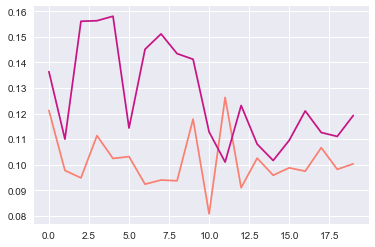

In [17]:
plt.plot(updates["train_loss"], color="salmon")
plt.plot(updates["test_loss"], color="mediumvioletred")

In [16]:
# - EOF - 